# Analysis of inter-embryo variability using Kullback-Leibler divergence across genetically identical embryos

### *Gene expression variance and invariance across sibling embryos. We devised a framework to quantify gene expression differences across individual embryos. Our framework relies on estimating probability distributions of gene expression across single cells for each embryo and applying an information-theoretic approach to quantify the differences between those distributions.*


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


from scipy.special import rel_entr, kl_div
from scipy.special import softmax
from scipy.stats import entropy
from scipy import stats

## 1. Preparing the adata to get the Inter-Embryo Divergence dataframe for a single timepoint

### We prepare the adata object:
* Choose a single timepoint for the analysis
* Find cell clusters with at least 80 cells per embryo
* If we want to compute the analysis for the entire embryo, we call the function 'make_columns' with the annotation 'cell_type_1'. Otherwise, we call the function with the desired cell clusters, and the column in which the cell cluster labels can be found


In [18]:
# function: subsets adata for a timepoint
# arguments: adata object and desired timepoint
# output: subset adata object
    
def myadata(adata, timepoint):
    myadata = adata[adata.obs.timepoint == timepoint].copy()
    
    return myadata

In [ ]:
# function: gets the cell clusters that have at least 80 cells per embryo
# arguments: adata object and column for cell cluster label
# output: list of cell clusters that pass the threshold of 80 cells/embryo

def get_cell_clusters(adata, celltypecolumn = 'ontology_class'):
    myfish = adata.obs.fish.unique()
    celltypes = []

    for fish in myfish:
            counts = adata.obs[adata.obs.fish == fish][celltypecolumn].value_counts()
            l = counts[counts > 80].index.tolist()
            celltypes += l
            
    alltypes = set([x for x in celltypes if celltypes.count(x) == 4])
    return list(alltypes)

In [19]:
# function: some preprocessing, go from adata object to input for 
# input: adata object, and either a list of cell types with the cell type column name, or 'cell_type_1' if whole embryo
# output: adata with new 'Cells_Annotations' column, the cell type(s) of interest for analysis

def make_columns(adata, annotations = ['cell_type_1'], celltypecolumn = 'ontology_class'):
    
    if annotations[0] == 'cell_type_1':
        newadata = adata.copy()
        newadata.obs['Cells_Annotations'] = 'cell_type_1'
        
    else:
        newadata = adata[adata.obs[celltypecolumn].isin(annotations)].copy()
        newadata.obs['Cells_Annotations'] = newadata.obs[celltypecolumn].copy()
        
    
    return newadata


## *Example code:*
* Upload adata object
* Chose timepoint and get subset adata ('myadata' function)
* Find potential cell clusters to run analysis with at least 80 cells per embryo ('get_cell_clusters' function)
* Make a column with the cell type, either a list of cell types found in the cell type column, or for 'cell_type_1' if the analysis is for whole embryo ('make_columns'). *__The process must be run separately for either cell type(s) or the whole embryo.__*
* Now we have our example_adata, ready to run the inter-individual analysis

In [46]:
adata = sc.read_h5ad('/mnt/ibm_lg/alejandro/danio-atlas/atlas_objects/early_timepoints/danio_atlas_umapv2_annotated.h5ad')
example_adata = myadata(adata, '05somite')

In [48]:
get_cell_clusters(example_adata, 'annotation_umapv2_global')

['epithelium', 'neural_anterior', 'PSM', 'neural_posterior']

In [49]:
example_adata = make_columns(example_adata, ['neural_anterior'], 'annotation_umapv2_global')

## 2. Inter-individual analysis (mpKLD)

#### **Computes the median pairwise Kullback-Leibler divergence (mpKLD) across genetically identical embryos for a single cell cluster and single timepoint**

* Takes the log normalized counts grouped by embryo for each gene
* Excludes genes that have less than 10 non-zero counts for each embryo
* Fits a probability density function for the expression of each gene (for each individual embryo per time point) using a Gaussian kernel
* Uses the Kullback-Leibler divergence to estimate, for each gene and per stage, all pairwise divergences between embryo gene count distributions

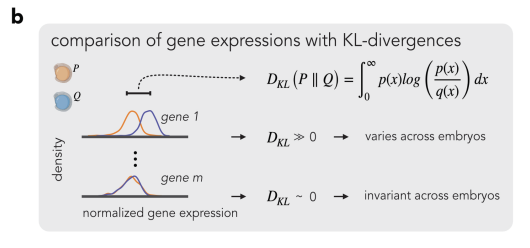

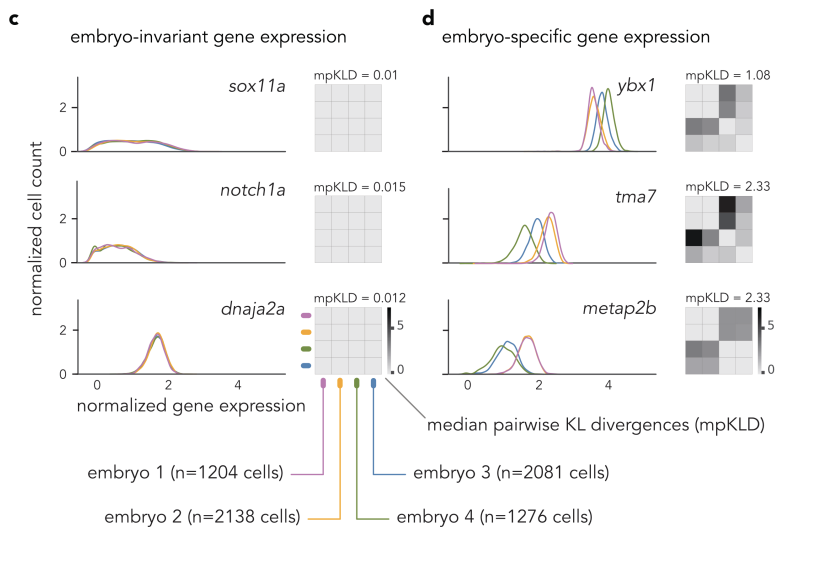

In [6]:
# function: calculation of KL for two numpy arrays
# arguments: two numpy arrays
# output: mpKLD score (float)

def kl_divergence(fish1gene = [],  fish2gene = []):
    
    
    pkde = stats.gaussian_kde(np.array(fish1gene))
    qkde = stats.gaussian_kde(np.array(fish2gene))
    maxval = np.max([np.max(fish1gene), np.max(fish2gene)])
    minval = np.min([np.min(fish1gene), np.min(fish2gene)])
    
    ### check gaussian_kde, no parameter that could change results (ie. range)
    offset = 1
    newx = np.linspace(minval-offset, maxval+offset,1000)
    
    p = pkde.pdf(newx)
    q = qkde.pdf(newx)
    
    newp = np.where(p< 1e-9, 1e-9, p)
    newq = np.where(q< 1e-9, 1e-9, q)

    
    kl_pair = stats.entropy(newp, newq)
    return kl_pair

Gets the arrays of RNA counts for the gene/cell type for a pair of fish

In [7]:
# function: helper to make the matrix, gets the specific arrays and sends to kl function
# arguments: matrix of counts (sparse), gene, cell type, two fish (str), layer (log/scaled str), obs and var from adata as pd.DF
# output: kl divergence score for two arrays (calls kl function)

def kl_fishpair_genecelltype2(matrix = [[],[]], gene = 'phtf2', cluster = 'Somite', fish1 = '44', fish2 = '46', obs=pd.DataFrame, var=pd.DataFrame):
       
 
    row1 = obs['fish'].loc[lambda x: x==fish1].index.tolist()
    row2 = obs['fish'].loc[lambda x: x==fish2].index.tolist()
    
    myindex = int(var.index[var['index']==gene].tolist()[0])
    

    q = np.asarray(matrix.tocsr()[row1, myindex].todense()).flatten()
    p = np.asarray(matrix.tocsr()[row2, myindex].todense()).flatten()
    
    if (np.sum(p > 0) < 10) or (np.sum(q > 0) < 10):
        return -1
    else:
        return kl_divergence(q, p)

Makes a matrix of pairwise fish

In [8]:
# function: makes a matrix with the pairwise KL values
# arguments: takes in a matrix of counts (sparse), a gene, cell type, list of fish (str), layer (log/scaled str), obs and var from adata as pd.DF
# output: a matrix with all pairwise KL scores for the fish

def kl_fish_matrix2(matrix = [[],[]], gene = 'phtf2', cluster = 'Somite', fish = [], obs =pd.DataFrame, var=pd.DataFrame):

    fishcols = []
    
    for f1 in fish:
        f1row = []
        for f2 in fish:
            value = kl_fishpair_genecelltype2(matrix, gene, cluster, f1, f2, obs, var)
            
            if (value == -1):
                return -1
            f1row.append(value)
        fishcols.append(f1row)      

    return fishcols 

Summarizes the pairwise fish matrix (excluding the diagonal elements, compared to self) by the numpy method (i.e. np.mean) specified

In [9]:
# function: calculates summary metric of kl matrix pairwise scores, not including the diagonal elements
# arguments: matrix with kl pairwise scores, summary method metric (numpy)
# output: single summary number of matrix (float)

def kl_matrix_summary3(myfishmatrix, method = np.max):
    testmatrix = np.array(myfishmatrix)
    numzeros = len(testmatrix)
    newx = np.sort(testmatrix, axis=None)
    
    allelem = newx[numzeros:]

    

    return method(allelem)

Function that calls the process for a specific gene and builds the mpKLD dataframe

In [10]:
# function: return a dataframe with the desired KL metric summaries for specified genes, for a certain cell type
# arguments: adata object, list of genes, cell type (str), list of fish (str), layer (log/scaled str), list of np summary methods (mean/median, etc)
# output: pd dataframe, with columns gene, cluster (cell type), and summary methods


def KL_metrics_genecluster(adata = [], gene = [], cluster = 'Somite', myfish = [], method = [], timepoint = '12hpf'):
    
    myadata = adata[adata.obs['Cells_Annotations'] == cluster].copy()
    a_var = myadata.var.copy().reset_index()
    a_obs = myadata.obs.copy().reset_index()
    newmatrix = myadata.X.copy()
    
    mygenes = []
    generow = {}
    for g in gene:
        mymatrix = kl_fish_matrix2(newmatrix, g, cluster, myfish, a_obs, a_var)
        
        #if running for nonsiblings, use the MOD functions
        #mymatrix = kl_fish_matrix_MOD(newmatrix, g, cluster, myfish, a_obs, a_var)
        
        if mymatrix == -1:
            continue
        
        generow = {'gene': g, 'cluster': cluster}
        for m in method:
            stat = kl_matrix_summary3(mymatrix, m)
            #stat = kl_matrix_summary_MOD(mymatrix, m)
            
            generow[m.__name__] = stat

        mygenes.append(generow)
    
       
    bigframe = pd.DataFrame.from_dict(mygenes)
    bigframe['timepoint'] = timepoint
    return bigframe

We call this function to compute the mpKLD dataframe

In [11]:
# function: creates a dataframe with KL metrics, per gene, grouped by cell type
# arguments: adata, list of cell types/annotations, out_path as str, title as string 
# output: returns a dataframe with KL metrics per gene, per cell type

def KLdf(adata = [], annotations = ['Hindbrain'], myfish = [], timepoint = 'hpf'):
    KLframes = []
    mymetrics = [np.max, np.min, np.median, np.std, np.mean]
    mygenes = np.asarray(adata.var_names)
    for a in annotations:
        miniframe = KL_metrics_genecluster(adata, mygenes, a, myfish, mymetrics, timepoint)
        KLframes.append(miniframe)


    KL_metrics = pd.concat(KLframes, axis=0)
    
    return KL_metrics

### Creates and saves the mpKLD dataframe
#### *This is the function we call to create and save the mpKLD dataframe. We input the singular timepoint adata object and the cell types we want to run, and include the title and path to place to save the dataframe*

In [12]:
# function: exports a csv dataframe with KL metrics, per gene, grouped by cell type
# arguments: adata, list of cell types/annotations, out_path as str, title as string 
# output: saves a CSV dataframe with KL metrics per gene, per cell type at the out_path

def saveKLdf(adata = [], annotations = ['Hindbrain'], out_path = '', save_title = 'date', timepoint = 'hpf'):
    myfish = adata.obs['fish'].unique()
    KL_metrics = KLdf(adata, annotations, myfish, timepoint)
    

    KL_metrics.to_csv(out_path + save_title + 'Inter.csv')
    
    return KL_metrics


## *Example code:*

* We use our 'example_adata = make_columns(example_adata, ['periderm'], 'zebrafish_anatomy_ontology_class')' from earlier
* The timepoint variable should include 'hpf' hours post fertilization for later processing
* We define the path to save and the title of the csv, it will be saved as out_path + save_title + 'Inter.csv'

In [51]:
myout_path = '/mnt/ibm_lg/sarah.ancheta/ZF_atlas/intra_inter_v4/'
mysave_title = '12hpfneural_anterior_test'

In [52]:
saveKLdf(adata = example_adata, annotations = ['neural_anterior'], out_path = myout_path, save_title = mysave_title, timepoint = '12hpf')

,gene,cluster,amax,amin,median,std,mean,timepoint
0,dusp16,neural_anterior,0.261198,0.029645,0.097689,0.074098,0.120829,12hpf
1,crebl2,neural_anterior,0.539284,0.013008,0.094230,0.153668,0.148002,12hpf
2,ptpro,neural_anterior,0.144621,0.008180,0.073261,0.044665,0.072231,12hpf
3,ptpro-1,neural_anterior,0.327170,0.028177,0.120980,0.091118,0.145073,12hpf
4,msgn1,neural_anterior,0.131384,0.023262,0.049207,0.034179,0.059770,12hpf
...,...,...,...,...,...,...,...,...
9658,mt-nd4,neural_anterior,0.162960,0.023132,0.089915,0.048824,0.098980,12hpf
9659,NC-002333.16,neural_anterior,0.827113,0.034507,0.246398,0.213439,0.285967,12hpf
9660,mt-nd5,neural_anterior,0.115877,0.033126,0.067860,0.025207,0.071723,12hpf
9661,mt-nd6,neural_anterior,0.691310,0.011723,0.223387,0.225308,0.277233,12hpf


## 3. Null model for mpKLD through embryo ID randomization

#### *Gives us the expected mpKLD values if the differences between embryos were due to chance alone* 

* To establish a negative control and to gain a baseline for the difference in mpKLD between embryos (for a specific gene), we performed a bootstrap-like method
* Each cell has an embryo-specific ID, which we randomly reassigned
* We then repeated the inter-embryo diversity analysis process as described above
* We repeated this process n = 20 times

In [32]:
# function: saves a csv pandas DF with intrafish metrics, with numrandomstates different random scrambled fish states
# arguments: adata, cell types list of str, out_path (str) and title to save (str)
# output: csv with scrambled fish, same as intrafish DF but with added column of the random state

def scrambledInterFish(adata = [], annotations = ['Hindbrain'], numrandomstates = 20, timepoint = 'hpf'):
    
    scrambleDFframes = []
    myfish = adata.obs['fish'].unique()
    
    for i in range(numrandomstates):
        adata1 = adata.copy()
        adata1.obs['fish'] = np.random.RandomState(seed=i).permutation(adata1.obs['fish'].values)
        state = str(i)
        
        fishscramble = KLdf(adata1, annotations, myfish, timepoint)
        fishscramble['Random_State']='mixed_fish' + state
        scrambleDFframes.append(fishscramble)
        
        
    scrambleInter = pd.concat(scrambleDFframes, axis=0)
    
    
    return scrambleInter


In [33]:
# function: saves scrambled (null) df with KL analysis
# arguments: adata, list of cell types/annotations, number of randomzied iterations, out_path as str, title as string 
# output: returns a dataframe with KL metrics per gene, per cell type, with random state column (which iteration of random)

def save_scrambledInter(adata = [], annotations = ['Hindbrain'], numrandomstates = 20, out_path = '', save_title = 'date', timepoint = 'hpf'):
    
    mydf = scrambledInterFish(adata, annotations, numrandomstates, timepoint)
    mydf.to_csv(out_path + save_title + 'null_scramble.csv')
    
    return mydf

## *Example code:*

* Same as above for the mpKLD dataframe, but now include the number of random iterations
* We use our 'example_adata = make_columns(adata12hpf, ['periderm'], 'zebrafish_anatomy_ontology_class')' from earlier
* The timepoint variable should include 'hpf' hours post fertilization for later processing
* We define the path to save and the title of the csv, it will be saved as out_path + save_title + 'Inter.csv'

In [53]:
myout_path = '/mnt/ibm_lg/sarah.ancheta/ZF_atlas/intra_inter_v4/'
mysave_title = '12hpfneural_anterior_test_null_randomized'

In [ ]:
save_scrambledInter(adata = example_adata, annotations = ['neural_anterior'], numrandomstates = 20, out_path = myout_path, save_title = mysave_title, timepoint = '12hpf')

## Modified functions to use for replicate fish, to generate the pairs of non-siblings

In [3]:
def kl_fish_matrix_MOD(matrix= [[],[]], gene = 'phtf2', cluster = 'Somite', fish = [], obs =pd.DataFrame, var=pd.DataFrame):
    
    newfish = fish[0]
    oldfish = fish[1]
    fishcols = []
    
    for f1 in newfish:
        f1row = []
        f2row = []
        for f2 in oldfish:
            value = kl_fishpair_genecelltype2(matrix, gene, cluster, f1, f2, obs, var)
            
            if (value == -1):
                return -1
            f1row.append(value)
            value2 = kl_fishpair_genecelltype2(matrix, gene, cluster, f2, f1, obs, var)
            
            if (value2 == -1):
                return -1
            f2row.append(value2)
        fishcols.append(f2row)
        fishcols.append(f1row)
            
    return fishcols  

In [4]:
def kl_matrix_summary_MOD(myfishmatrix, method = np.max):
      
    testmatrix = np.array(myfishmatrix)
    
    return method(testmatrix)

## Example: we run for the nonsiblings, created with the MOD functions as pairs from two sets of siblings
* We upload two adata objects with two sets of sibling
* Ensure the sample column 'fish' is the same across the two objects and concat the adata objects
* We ensure the function 'KL_metrics_genecluster' is using the MOD functions
* Run the KLdf function as before, with the list of samples (myfish_list) with two nested lists, the first set corresponding to the first set of siblings and second set corresponding to the second set
* We run the same pathway analysis and filtering as outlined in the notebook Inter-Embryo_Divergence_PathwayAnalysis_Plots.ipynb, and analyze the top 2% and bottom 2% of overlapping genes across the first set of siblings, the second set of siblings, and the nonsibling computation.

In [ ]:
newadata = sc.read_h5ad('/home/sarah.ancheta/bruno1/projects/data.science/alejandro/danio-atlas/processed_objects/ZF_24h_19h_secondReplicate_03102023.h5ad')

In [ ]:
adata24_new = newadata[newadata.obs.time_point == '24 hpf'].copy()
adata24_new.X = adata24_new.layers['counts']
adata24_new.obs['fish'] = adata24_newfish.obs['fish_id'].copy()

In [ ]:
adata24_new.obs.fish_id.unique()

In [ ]:
oldadata = sc.read_h5ad('/home/sarah.ancheta/bruno1/projects/data.science/alejandro/danio-atlas/zebrahub/final_objects/v4/zf_atlas_full_v4_release.h5ad')

In [ ]:
adata24_old = oldadata[oldadata.obs.timepoint == '24hpf'].copy()
adata24_old.X = adata24_old.layers['counts']

In [ ]:
combo_fish_adata = ad.concat([adata24_newfish, adata24_oldfish]).copy()

In [ ]:
adata_MOD = scale_adata(combo_fish_adata)

In [ ]:
adata_MOD = make_columns(adata_MOD, ['cell_type_1'])

In [ ]:
myfish_list = [['TDR106', 'TDR107', 'TDR108', 'TDR109'], ['TDR43', 'TDR46', 'TDR44', 'TDR45']]

In [ ]:
KL_metrics = KLdf(adata_MOD, ['cell_type_1'], myfish_list, mytimepoint)
    
KL_metrics.to_csv(myout_path + mysave_title_embryo + 'Inter.csv')

KL_metrics